In [1]:
import xarray as xr
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np

import lagtraj.domain.load
import lagtraj.trajectory.load
import lagtraj.trajectory.plot

%matplotlib inline

/home/earlcd/anaconda2/envs/ghana-training/lib/python3.6/site-packages/distributed/config.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config.update(yaml.load(text) or {})


Running without numba


In [2]:
ds_forcing = xr.open_dataset('../data/forcings/eurec4a_20191209_12_lin.nc')
ds_domain = lagtraj.domain.load.load_data(root_data_path="../data", name=ds_forcing.domain_name)
ds_traj = lagtraj.trajectory.load.load_data(root_data_path='../data', name=ds_forcing.trajectory_name)

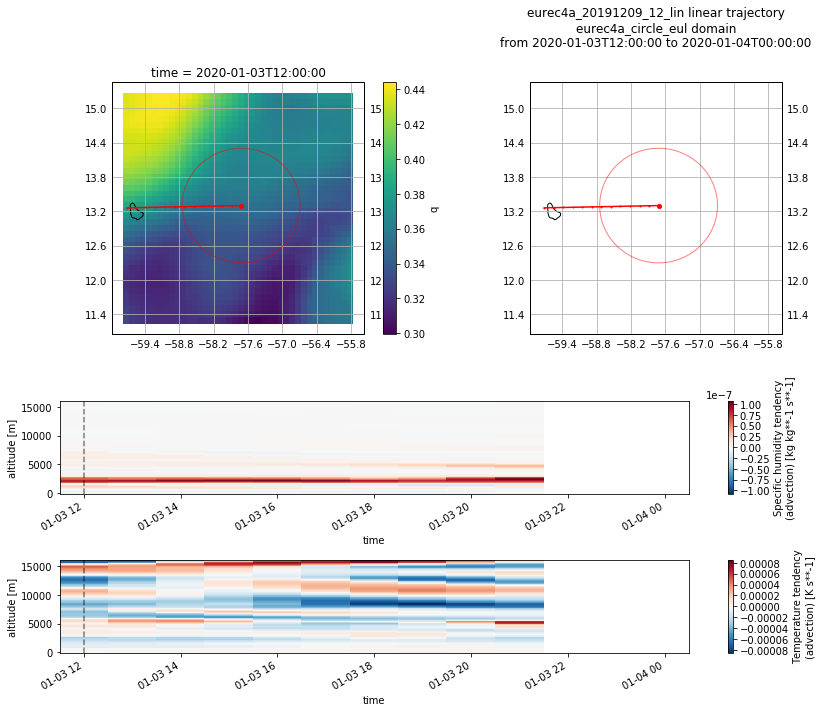

In [5]:
forcing_vars = ["dqdt_adv", "dtdt_adv"]
domain_var = 'q'
figwidth = 12
subplot_height = 3
tn = 0
overview_window_width = 4 # [deg]
traj_color = 'red'

N_vars = len(forcing_vars)
figsize = (figwidth, 4+subplot_height*N_vars)
fig = plt.figure(figsize=figsize)
gs = GridSpec(2+N_vars, 2)
ds_forc_tn = ds_forcing.isel(time=tn)
lat0, lon0 = ds_forc_tn.lat, ds_forc_tn.lon
domain_window = dict(
    lat=slice(lat0-overview_window_width/2, lat0+overview_window_width/2),
    lon=slice(lon0-overview_window_width/2, lon0+overview_window_width/2),
    time=ds_forc_tn.time
)
da_domain = ds_domain[domain_var].sel(**domain_window).sum(dim='level')['q']

#proj_overview = ccrs.Orthographic(central_latitude=lat0, central_longitude=lon0)
proj_overview = ccrs.PlateCarree()

def add_overview_axes(gs_):
    ax = fig.add_subplot(gs_, projection=proj_overview)
    ax.coastlines(resolution='10m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    return ax

ax_domain = add_overview_axes(gs[:2,0])
da_domain.plot(ax=ax_domain)
ax_satellite = add_overview_axes(gs[0:2,1])
ax_satellite.set_extent(ax_domain.get_extent())
#da_domain.plot(ax=ax_satellite)

traj_plot_kwargs = dict(ds=ds_traj, add_ref='eurec4a_circle',
                             color=traj_color, reference_time=ds_forc_tn.time)
lagtraj.trajectory.plot.main(ax=ax_domain, **traj_plot_kwargs)
lagtraj.trajectory.plot.main(ax=ax_satellite, **traj_plot_kwargs)


ax = None
for n, v in enumerate(forcing_vars):
    ax = fig.add_subplot(gs[n+2,:], sharex=ax)
    ds_forcing[v].plot(ax=ax, y="level")
    # .item() doesn't return a np.datetime64 object sadly, so we have to make our own...
    t0 = np.datetime64(ds_forc_tn[v].time.item(), 'ns')
    ax.axvline(x=t0, color='black', linestyle='--', alpha=0.5)
    
fig.tight_layout()

In [4]:
ds_traj

<xarray.Dataset>
Dimensions:          (time: 13)
Coordinates:
  * time             (time) datetime64[ns] 2020-01-03T12:00:00 ... 2020-01-04
Data variables:
    lat              (time) float64 ...
    lon              (time) float64 ...
    u_traj           (time) float64 ...
    v_traj           (time) float64 ...
    origin_lat       float64 ...
    origin_lon       float64 ...
    origin_datetime  datetime64[ns] ...
Attributes:
    trajectory_type:  linear
    U:                (-5.0, -0.1)
    name:             eurec4a_20191209_12_lin
    domain_name:      eurec4a_circle_eul